# Métodos Numéricos 2024

## Guía 4: 2024-05-02 - Ajuste por Cuadrados Mínimos

In [21]:

using Plots
using LaTeXStrings
using DataFrames
using CSV
using LsqFit
using LinearAlgebra

###  Problema 1 

Escriba una función de Julia que permita encontrar la mejor recta que aproxime un conjunto de $n$ puntos utilizando el **método de cuadrados mínimos**.
La función tiene que tomar como argumentos dos vectores que contengan las coordenadas $x_i$ e $y_i$ de los $n$ puntos.
La función debe retornar una tupla $(a_0,a_1)$ con los coeficientes $a_0$ y $a_1$ de la recta $y(x) = a_0 + a_1 x$ que ajusta los puntos.

In [2]:
function cof_min_sqrt(xi, yi)
    n = length(xi)
    @assert n == length(yi)
    
    sum_xi = sum(xi)
    sum_yi = sum(yi)
    sum_xi_sq = sum(xi.^2)
    sum_xy = sum(xi.*yi)
    
    a1 = (n * sum_xy - sum_xi * sum_yi) / (n * sum_xi_sq - sum_xi^2)
    a0 = (sum_yi - a1 * sum_xi) / n
    
    return (a0, a1)
end

function min_sqrt(x,xi,yi)
    a,b = cof_min_sqrt(xi,yi)
    p = a + b*x 
    return p
end

min_sqrt (generic function with 1 method)

### Problema 2 : Ajuste de una recta

Utilice el programa del problema anterior para ajustar por cuadrados mínimos los datos del ejemplo $1$ del teórico. Grafique, junto con la recta obtenida, los puntos originales cuyas coordenadas se proveen en la siguiente tabla.


| $x_i$ | $y_i$ |
| ---   | ---   |
| $1$   | $1,3$ |
| $2$   | $3,5$ |
| $3$   | $4,2$ |
| $4$   | $5,0$ |
| $5$   | $7,0$ |
| $6$   | $8,8$ |
| $7$   | $10,1$|
| $8$   | $12,5$|
| $9$   | $13,0$|
| $10$  | $15,6$|

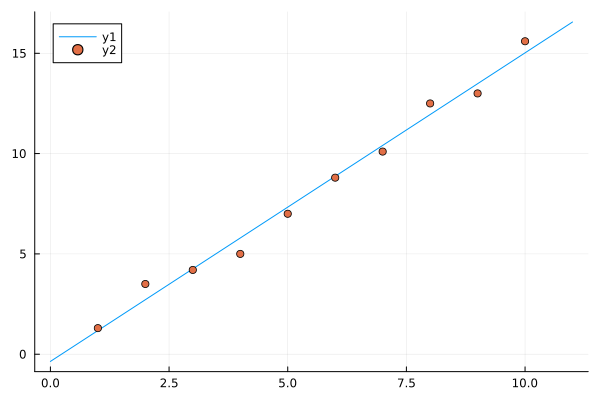

In [3]:
xi = [1,2,3,4,5,6,7,8,9,10]
yi = [1.3,3.5,4.2,5.0,7.0,8.8,10.1,12.5,13.0,15.6]
r(x) = min_sqrt(x,xi,yi)
n = length(yi)
plot(0:0.01:11,r)
scatter!(1:n,i->(yi[i]),yscale =:identity)

### Problema 3 : Paquete `LsqFit`

Utilice el paquete de Julia `LsqFit` para ajustar los datos del **Problema 2**. Para ello, 

* defina la función de ajuste,
* y proporcione valores iniciales para los parámetros de ajuste.

En este caso, serán $a_0$ y $a_1$ los parámetros que a ajustar para minimizar la diferencia entre la función y los datos experimentales.
Comparar resultados con los obtenidos en el **Problema 2**. Para ello, grafique los puntos, y el ajuste con `LsqFit` y, nuevamente, el ajuste del **Problema 2**.

In [4]:
@. model(x, p) = p[1]*exp(-x*p[2])
p0 = [0.5, 0.5]
a,b = p0
fit = curve_fit(model, xi, yi, p0)


LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}, Vector{LsqFit.LMState{LsqFit.LevenbergMarquardt}}}([2.6069155677392684, -0.18348290045121377], [1.8319338215336158, 0.26268782305542304, 0.32047216209597007, 0.43087004004786333, -0.4753830276406168, -0.9613615641546573, -0.6827035076217012, -1.1861125243625974, 0.5924413036143044, 0.7298831626210269], [1.2013944219436081 -3.131933821523243; 1.4433485570580278 -7.52537564628384; … ; 5.213993683508319 -122.33197179311819; 6.264062927318456 -163.29883172616076], true, Iter     Function value   Gradient norm 
------   --------------   --------------
, Float64[])

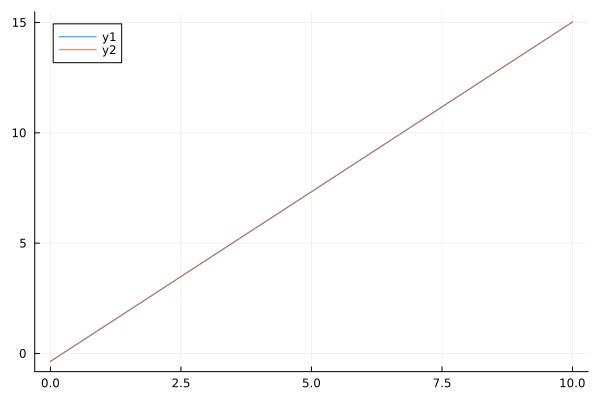

In [5]:
@. model(t, p) = p[1] + p[2] * t
p0 = [0.2,2]
fit = curve_fit(model, xi, yi, p0)
param = fit.param
fita(y) = param[1] + param[2]*y
plot(0:0.1:10,fita)
plot!(r)

### Problema 4 : Ajuste de modelo lineal

Supongamos que tenemos una serie de datos $\{x_i,y_i:i=1,...,n\}$ y que queremos ajustar un modelo $f$ definido por

$$
f(x,p) = p_1f_1(x)+p_2f_2(x)+...+p_mf_m(x)
$$

donde $f_1,f_2,...,f_m$ son algunas funciones de $x$ y $p_1,...,p_m$ son parámetros correspondientementes. Notar que $f$ depende linealmente de los parámetros. En particular, siempre se elige $f_1(x)=1$.

El Error Cuadrático

$$
d(p) = \sum_{i=1}^n (f(x_i,p)-y_i)^2
$$

es una medida de distancia que cuantifica cuán bien (o mal) la función $f$ ajusta los datos para cada elección de los parámetros. Su minimización con respecto al vector $p$ permite encontrar el ajuste óptimo. Las condiciones que determinan el valor de $p$ que minimiza $d$ pueden expresarse como un sistema lineal de $m$ ecuaciones para $m$ incógnitas (ver la derivación teórica abajo) 
$$
Ap = b
$$


1. Cargue los datos provistos en el archivo `cuadratica.dat` en dos vectores $x$ e $y$, y luego grafíquelos utilizando puntos.

2. Con dichos vectores, calcule la matriz $A$ y el vector $b$ para el caso particular en que $f_1(x) = 1$, $f_2(x) = x$ y $f_3(x) = x^2$.

3. Utilice $A$ y $b$ para encontrar el mejor ajuste $p$, y grafique el modelo ajustado junto a los datos.

4. Calcule la estimación de los errores de los parámetros ajustados (ver teoría abajo).

5. Repita el ajuste usando el paquete `LsqFit` y compare resultados.

### Teoría

##### Ajuste

Notar que el EC puede reescribirse matricialmente como

$$
d(p) = \sum_{i=1}^n (f(x_i,p)-y_i)^2 = (Fp-y)'(Fp-y) = |Fp-y|^2
$$

donde $p'=(p_1,p_2,...,p_m)$ es la forma traspuesta del vector $p$, $F$ es una matriz de $\mathbb{R}^{n\times m}$ de entradas $F_{ij} = f_j(x_i)$ e $y'=(y_1,...,y_n)$.

La construcción de dicha expresión matricial puede visualzarse facilmente de notar que buscamos el $p$ tal que

\begin{eqnarray}
p_1f_1(x_1)+...+p_mf_m(x_1) &\approx& y_1 \\
... && \\
p_1f_1(x_n)+...+p_mf_m(x_n) &\approx& y_n \\
\end{eqnarray}

Si $p$ minimiza globalmente a $d$, luego 
$$
\lim_{\epsilon \to 0} \frac{d(p+\epsilon q)-d(p)}{\epsilon}=0
$$
para todo vector $q$, o equivalentemente $(\nabla d)(p)=0$. Por otro lado, si bien la proposición recíproca no es generalmente cierta, la función a minimizar es una expresión cuadrática respecto de los parámetros en $p$, por lo que la condición $(\nabla d)(p)=0$ **sí** garantiza que $p$ sea mínimo global de $d$.

Para calcular el gradiente, reescribimos $d(p)$ (ver [1])

\begin{eqnarray}
d(p) &=& (Fp-y)'(Fp-y) \\
&=& (p'F'-y')(Fp-y) \\
&=& p'F'Fp - p'F'y - y'Fp + y'y \\
\end{eqnarray}

De esta manera, es fácil ver que (ver [2])

\begin{eqnarray}
\lim_{\epsilon\to 0}
\frac{d(p+\epsilon q)-d(p)}{\epsilon}
&=&
q'F'Fp + p'F'Fq - q'F'y - y'Fq
\\
&=&
q'(F'Fp-F'y) + (p'F'F-y'F)q
\\
&=&
q'c + c'q
\\
\end{eqnarray}

donde $F'$ es la traspuesta de $F$ y $c = F'Fp-F'y$.
Luego, $q'c + c'q=0$ se satisface para todo $q$ si y sólo si $c=0$, o equivalentemente, si y sólo si

$$
F'Fp=F'y
$$

Este es un sistema de ecuaciones lineales para $p$, 

$$
Ap=b
$$

donde $A:=F'F$ y $b:=F'y$.

Como comentario final, si las columnas de $F$ son linealmente independientes (típicamente lo son), luego $A=F'F$ es invertible y, por ende, $p=A^{-1}b=(F'F)^{-1}F'y$.
Aquí, $F^+:=(F'F)^{-1}F'$ es la denominada matriz pseudo-inversa de Moore-Penrose (ver [3]).

##### Estimación de errores

$\newcommand{\avrg}[1]{\langle #1 \rangle}$
Una estimación de la varianza del $i$-ésimo parámetro $p_i$ debido a los errores experimentales en las mediciones de los valores $y_j$ viene dada por (ver [4])

$$\mathrm{Var}(p_i) = \sigma^2 (F'F)^{-1}_{ii}$$

donde

$$\sigma^2 = \frac{1}{n-m}d(p)$$

es un estimador de la varianza del ruido en los valores de los $y_j$. Luego, una estimación del error asociado al $i$-ésimo parámetro $p_i$ es la raíz cuadrada de dicha varianza, $\sqrt{\mathrm{Var}(p_i)}$.

**Referencias**

[1] https://www.youtube.com/watch?v=jezAWd6GFRg

[2] https://math.stackexchange.com/questions/20694/vector-derivative-w-r-t-its-transpose-fracdaxdxt

[3] https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse

[4] https://stats.stackexchange.com/questions/216335/standard-error-for-a-parameter-in-ordinary-least-squares

**Ayuda:** Para cargar los datos, utilice los paquetes `CSV` y/o `DataFrames`, o utilice el código:

In [60]:
delimitador = ' '

datos = CSV.File("cuadratica.dat", delim=delimitador)

# Convierte los datos a un DataFrame de Julia
df = DataFrame(datos)

# Muestra los primeros 5 filas del DataFrame
show(first(df,5))

5×2 DataFrame
 Row │ xi       yi      
     │ Float64  Float64 
─────┼──────────────────
   1 │     1.0  3.06006
   2 │     1.2  4.18898
   3 │     1.4  4.78323
   4 │     1.6  5.4862
   5 │     1.8  6.50059

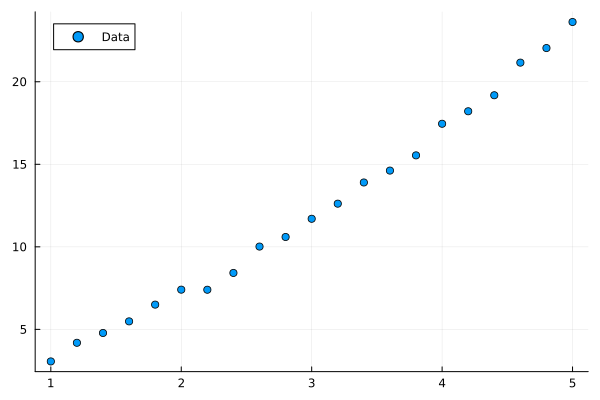

In [61]:
xii = zeros(21)
yii = zeros(21)
for i in 1:21
xii[i],yii[i] = datos[i]
end

scatter(xii,yii,label ="Data")

In [71]:
f(x) = [1,x,x^2]
largof = length(f(1))
largoxii = length(xii)
F = zeros(largof,largoxii)


3×21 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [112]:
for j in 1:largof
    for i in 1:largoxii
    F[j,i] = f(xii[i])[j]
    end 
end

FT = transpose(F)
A = F*FT
b = F*yii

p = A\b

g(x) = p[1]*1+p[2]*x+p[3]*x^2

scatter(xii,yii,label ="Data")
plot!(g,label = "Fit")


3×21 Matrix{Float64}:
 1.0  1.0   1.0   1.0   1.0   1.0  1.0   …   1.0    1.0    1.0    1.0    1.0
 1.0  1.2   1.4   1.6   1.8   2.0  2.2       4.2    4.4    4.6    4.8    5.0
 1.0  1.44  1.96  2.56  3.24  4.0  4.84     17.64  19.36  21.16  23.04  25.0

In [116]:
#CALCULO ERROR
dp = sum((g.(xii)-yii).^2)
σ2 = dp/(largoxii-largof)
Δp = zeros(largof)

for i in 1:largof
    Δp[i] = sqrt.(σ2*(FT*F)[i,i])
end
return Δp

    

3-element Vector{Float64}:
 0.4882333056271501
 0.5988641412992056
 0.7351438334860586

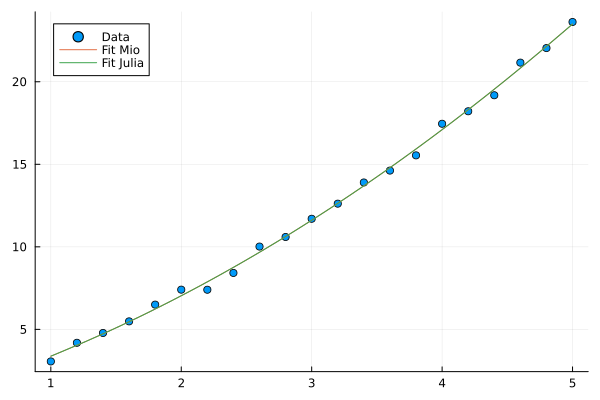

In [117]:
@. model(t, p) = p[1] + p[2] * t + p[3] * t^2
p0 = [0.5,0.5,0.5]
fiti = curve_fit(model, xii, yii, p0)
a,b,c = fiti.param
ajuste(y) = a + b*y + c*y^2 

scatter(xii,yii,label ="Data")
plot!(g,label = "Fit Mio")
plot!(ajuste,label = "Fit Julia",)

In [118]:
error_julia = estimate_errors(fiti)

3-element Vector{Float64}:
 0.8208011295489152
 0.602622420150622
 0.09884990792796952

### Problema 5 : Ajuste no lineal

1. Utilizando el paquete `LsqFit`, ajuste un conjunto de mediciones almacenadas en el archivo de texto llamado `decaimiento.txt` con la función 
$$
F(t) = A \exp\bigg(-\frac{t}{T}\bigg)
$$

2. Determine los valores de $A$ y $T$ ajustados.

3. Genere un gráfico que muestre tanto los datos medidos como la curva ajustada.

In [26]:
xi1 = (0.0:0.2:5.0)
yi1=[1.0981501410479229,0.9204139900570522,0.9117511107385388,0.7232300044209135,
    0.7418842218840357,0.6117598790626873,0.6441172633694129,
    0.5588143185296968,0.37208144464517207,0.371821100202616,
    0.4485373863532236,0.32210809541102325,0.3983050250962514,
    0.19393083833220928,0.2729883520205377,0.2770676660215884, 
    0.1417544035539918,0.15483186450676972,0.16838896348962007,
    0.2349171099122503,0.08258906026857732,0.17887847314164962,
    0.01754817726393937,0.05137155934456633,0.12508433706678887, 0.05576266701547357]


@. model(t, p) = p[1]*exp(-t/p[2])
p0 = [2, 0.4485373863532236]
fit1 = curve_fit(model, xi1, yi1,p0)
A,T = fit1.param

f(t) = A*exp(-t/T)

errores_estándar = estimate_errors(fit1)


2-element Vector{Float64}:
 0.07208720692786443
 0.20033376280772133

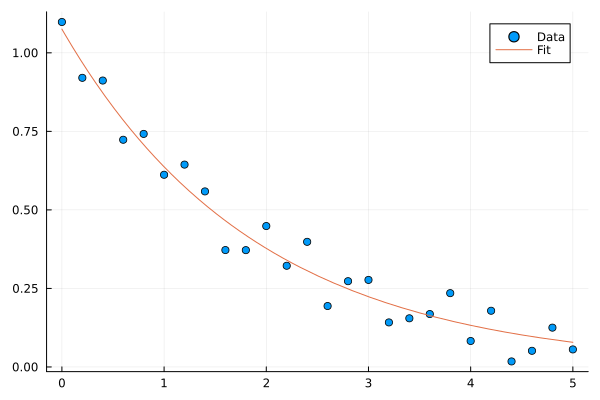

In [18]:
scatter(xi1,yi1,label = "Data")
plot!(f,label = "Fit")

## Ejemplos adicionales

### Problema 6 

El comportamiento de dos átomos ligados formando una molécula estable puede ser descripto en términos de las masas de los mismos, y una energía potencial $U(r)$ que depende de la distancia $r$ entre sus centros.
A distancias cortas, los átomos se repelen.
A distancias grandes, los átomos se atraen, manteniendo formada la molécula.
El potencial de Lennard-Jones es un modelo de $U(r)$ frecuentemente utilizado, y se define por
$$
U(r) = U_0 \bigg[ \bigg( \frac{r_0}{r} \bigg)^{12} - 2\bigg( \frac{r_0}{r} \bigg)^6  \bigg]
$$

Los parámetros $r_0$ y $U_0$ están empíricamente determinados por la molécula en consideración.
Distintas moléculas, requieren distintos valores de $r_0$ y $U_0$.
Para $r>r_0$ la pendiente de $U(r)$ es positiva, la fuerza es atractiva. 
Para $r<r_0$, la pendiente es negativa y la fuerza es fuertemente repulsiva.
Para $r=r_0$ la fuerza es nula (mínimo de la energía potencial) y por tanto la molécula está en equilibrio.

1. Grafique el potencial de Lennard-Jones usando $r_0=1[\mathring{A}]$ y $U_0=1[meV]$ para tener una idea de su forma.

2. Se realizaron mediciones del potencial $U(r)$ de una moleculada dada, a distintas distancias $r$. Los resultados obtenidos son:

    |$r$ [A] | $U(r)$ [meV] |
    |------|------------|
    |2.85  |  2.66542   |
    |2.90  |  1.01110   |
    |3.00  |  -1.07252  |
    |3.10  |  -2.11419  |
    |3.30  |  -2.67023  |
    |3.70  |  -2.00824  |
    |4.00  |  -1.41200  |
    |4.50  |  -0.75629  |
    |5.20  |  -0.32556  |
    |6.00  |  -0.13291  |
    |7.00  |  -0.04498  |
    |8.00  |  -0.01276  |

    donde $\mathring{A}$ indica una unidad de Angstrom. Determine los valores de $U_0$ y $r_0$ ajustando los datos de la tabla. Grafique simultaneamente los datos y el ajuste.

3. Considere la siguiente tabla e infiera que molécula fué medida

|Molécula  |$U_0$ [meV] |  $r_0$ [A] |
|----------|------|-----|
|Hidrógeno | 2.68 | 3.3 |
|Nitrógeno | 8.18 | 4.2 |
|Oxígeno   |10.11 | 3.9 |

### Problema 7

En este ejercicio aprenderá a leer los datos de un archivo similar el del ejercicio anterior, pero usando la librería `CSV.jl`. 

Ajuste los datos del archivo `math_pendulum.csv` con una función del tipo 

$$m(t,p) = p_1 + p_2\cos(p_3t + p_4)$$

1. Para ello, primero grafique los datos y obtenga parámetros aproximados a los fines de iniciar la búsqueda de los mejores parámetros.
2. Realize el ajuste con la librería `LsqFit`.
3. Grafique en un mismo gráfico los datos dados y la mejor aproximación.

**Ayuda:** para leer los datos use la siguiente expresión: